In [24]:
from datetime import datetime
import datetime as dtt
import time
import pytz
import matplotlib.pyplot as plt
%matplotlib inline
import re
import pandas as pd
import numpy as np


PATH = '\NoteBook\\AnalisesGeral'
COLUMNS_VMSTAT = ['date','time','r','b','avm','free','re','pi','po','fr','sr','cy','int','syscalls','cs','us','sy','idle','wa','pc','ec','fi','fo','forks','pending_I/O_waits','free_frame_waits','executable_filled_pages_faults','iodones','lock_misses','pct_swap_used','total_swap','numperm','instmem','numproc','entitled_capacity','online_lcpus','oneline_vcpus']
COLUMNS_PROCESS =['DATE','TIME', 'PID:RGROUP:RUSER:COMMAND', '%CPU', 'INTERVALTIME', 'CPUSECONDS', 'TOTALELAPSEDTIME', 'PPID', 'NI', 'VSZ']
COLUMNS_ERROS =['DateTime','PID', 'ERRO']


In [25]:
def convToInt(val):
    result = re.sub('\W', '' , val)
    return int(result)

def formatdatahora(x, y):
    datahora = x + ' ' + y[:-3]
    return datetime.strptime(datahora, '%Y-%m-%d %H:%M')


def formatdatahoraErro(x):

    return datetime.strptime(x[:-3], '%d/%m/%Y %H:%M')

def formathora(val):
    result = re.sub('\s+', '' , val)
    if len(result) < 6:
        
        m, s = result.split(':')
        m = int(m)
        s = int(s)
        #return dtt.timedelta(minutes=int(m), seconds=int(s))
        #return time.strptime(result, '%M:%S')
        return 0 + ((m + (s/60))/60)
    else:
        h, m, s = result.split(':')
        #return dtt.timedelta(hours=int(h), minutes=int(m), seconds=int(s))
        #return time.strptime(result, '%H:%M:%S')
        h = int(h) 
        m = int(m)
        s = int(m)
        return h + ((m + (s/60))/60)

def isolarcommand(val):
    result = re.sub('\d+:', '' , val)
    return result

In [32]:
dataframevmstat = pd.read_csv(PATH + '\\vmstatdset.txt',
                   sep='\s+',
                   engine='python', 
                   na_values='-', 
                   header=None ,
                   names=COLUMNS_VMSTAT ,
                   converters={'DATE': convToInt}
                   
                   )
dataframevmstat['DateTime'] = [formatdatahora(x, y) for x, y in dataframevmstat[['date','time']].values]
dataframevmstat = dataframevmstat.set_index('DateTime')
dataframevmstat = dataframevmstat.sort_values(by='DateTime')


In [36]:
dataframeErro = pd.read_csv(PATH + '\\ConsumoCSO.log',
                   sep=';',
                   engine='python', 
                   na_values='-', 
                   header=None ,
                   names=COLUMNS_ERROS ,
                   converters={'DateTime': formatdatahoraErro}
                   
                   )
dataframeErro = dataframeErro.set_index('DateTime')
dataframeErro = dataframeErro.sort_values(by='DateTime')
dataframeErro.head()

,PID,ERRO
DateTime,,
2018-10-14 01:31:00,676200,ERRO:************: [1] Entidade 00008: Paramet...
2018-10-14 01:31:00,690927,ERRO:************:Alteracao pra tratar qttenta...
2018-10-14 01:31:00,691034,ERRO:************:Marco status com E sem tenta...
2018-10-14 02:33:00,975807,ERRO:************: [1] Entidade 00008: Paramet...
2018-10-14 02:33:00,975965,ERRO:************:Alteracao pra tratar qttenta...


# -->VMSTAT

### Páginas Vituais Ativas 

Visualização de utilização de páginas vituais no périodo de <b>15/11/2018</b> à <b>27/11/2018</b>

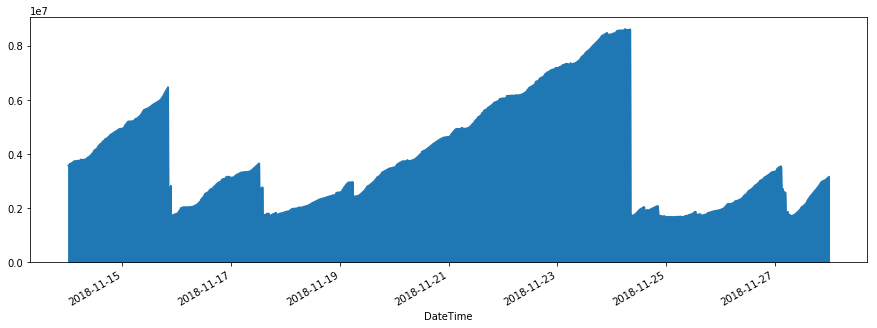

In [4]:
dataframevmstat['avm'].plot.area(figsize=(15, 5))

In [47]:
df2 =  dataframevmstat.sort_values(by=['avm'],ascending=False)
#df2['avm'].head(10)

### Análise Swapping 

<table>
    <tr>
        <th>Métrica</th>
        <th>Descrição</th>
    </tr>    
    <tr>
        <td>PI</td>
        <td>number of pages per second paged in from paging space</td>
    </tr>  
    <tr>
        <td>PO</td>
        <td>number of pages per second paged out to paging space</td>
    </tr> 
    <tr>
        <td>NOTE</td>
        <td>System may slow down when pi and po are consistently non-zero.</td>
    </tr> 
</table>


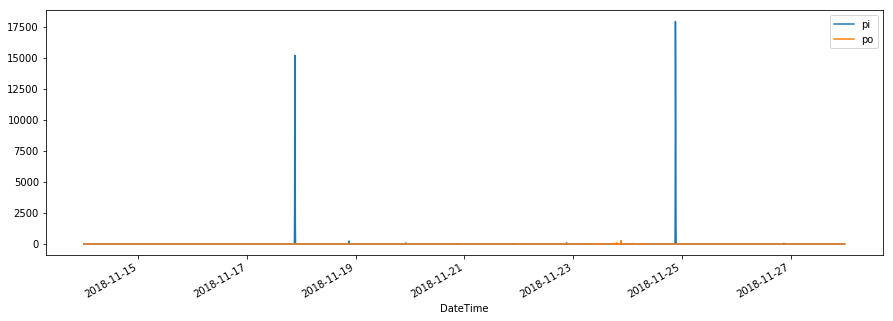

In [6]:
dfSW = pd.DataFrame()
dfSW ['DateTime'] = [formatdatahora(x, y) for x, y in dataframevmstat[['date','time']].values]
dfSW = dfSW.set_index('DateTime')
dfSW [['pi','po']] = dataframevmstat [['pi','po']]
dfSW.plot(figsize=(15, 5))

In [49]:
dfSW = dfSW.sort_values(by=['pi'],ascending=False)
#dfSW.head()

In [48]:
dfSW = dfSW.sort_values(by=['po'],ascending=False)
#dfSW.head()

### Análise Paging


<table>
    <tr>
        <th>Métrica</th>
        <th>Descrição</th>
    </tr>    
    <tr>
        <td>fr</td>
        <td> number of pages that must be freed to replenish the free list or
          to accommodate an active process</td>
    </tr>  
    <tr>
        <td>sr</td>
        <td>number of pages that must be examined in order to free fr number
          of pages</td>
    </tr> 
    <tr>
        <td>NOTE</td>
        <td>Memory is over-committed when the fr:sr ratio is high.</td>
    </tr> 
    <tr>
        <td>#</td>
        <td>An fr:sr ratio of 1:4 means for every one page freed, four pages must
     be examined. It is difficult to determine a memory constraint based on
     this ratio alone and what constitutes a high ratio is
     workload/application dependent.</td>
    </tr> 
</table>

In [9]:
def calcRelacao(fr, sr):
    return fr/sr
    

dfPG = pd.DataFrame()
dfPG ['DateTime'] = [formatdatahora(x, y) for x, y in dataframevmstat[['date','time']].values]
dfPG = dfPG.set_index('DateTime')
dfPG [['fr','sr']] = dataframevmstat [['fr','sr']]
dfPG['Relacao'] = [calcRelacao(x, y) for x, y in dfPG[['fr','sr']].values]
dfPG = dfPG.sort_values(by=['Relacao'],ascending=False)
dfPG['Relacao'].describe()

C:\Users\Inmetrics\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in longlong_scalars
  


count    1566.000000
mean        0.829525
std         0.218881
min         0.000000
25%         0.812500
50%         0.888889
75%         0.944444
max         1.000000
Name: Relacao, dtype: float64

In [50]:
dataframeprocess = pd.read_csv(PATH + '\\processdset.txt',
                   sep='\s+',
                   engine='python', 
                   na_values='-', 
                   header=None ,
                   names=COLUMNS_PROCESS,
                   converters={'TOTALELAPSEDTIME': formathora}          
                               
                               
                   )
dataframeprocess['DateTime'] = [formatdatahora(x, y) for x, y in dataframeprocess[['DATE','TIME']].values]
dataframeprocess = dataframeprocess.set_index('DateTime')
dataframeprocess = dataframeprocess.sort_values(by='DateTime')
dataframeprocess['COMMAND'] = [isolarcommand(x) for x in dataframeprocess['PID:RGROUP:RUSER:COMMAND'].values]
#dataframeprocess.head()

In [52]:
gp_process = dataframeprocess.groupby(['COMMAND']).agg({    
    'PPID': ['count']
})
gp_process = gp_process.sort_values(by=[('PPID', 'count')],ascending=False)
gp_process.head()

,PPID
,count
COMMAND,
tibco:sincvivo:servConsumidorCSO,1699
tibco:sincvivo:servConsumidorAtis,158
tibco:sincvivo:servConsumidorAtlys,109
system:root:bpbkar,4


### Tempo de execução de cada processo

 Objetivo do gráfico abaixo é observar o tempo de execução de cada processo na linha de tempo

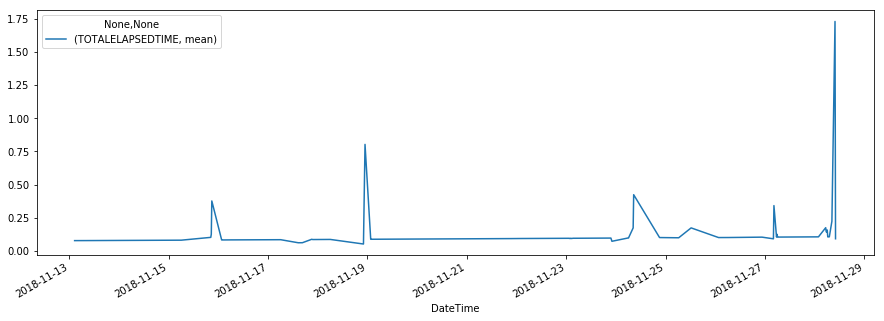

In [51]:
gp_teste = dataframeprocess.groupby([dataframeprocess.index]).agg({    
    'TOTALELAPSEDTIME': [np.mean]
})

gp_teste.plot(figsize=(15, 5))



In [53]:
gp_qtddeath = dataframeprocess.groupby([dataframeprocess.index]).agg({    
    'PPID': ['count']
})

### Quantidade de Processos na linha de tempo

 Objetivo do gráfico abaixo é apresentar a quantidade de processos na linha de tempo

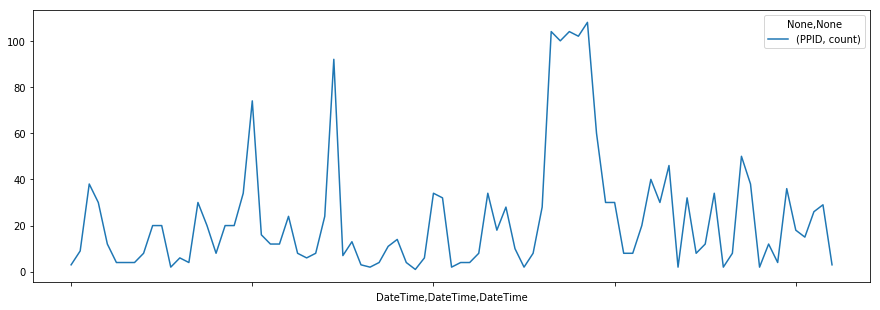

In [54]:

gp_totalppid1 = dataframeprocess.groupby([dataframeprocess.index.month, dataframeprocess.index.day, 
                                          dataframeprocess.index.hour]).agg({    
    'PPID': ['count']
})
gp_totalppid1.plot(figsize=(15, 5))

### Ocorrências de Erros

Objetivo do gráfico abaixo é apresentar a quantidade de erros na linha de tempo

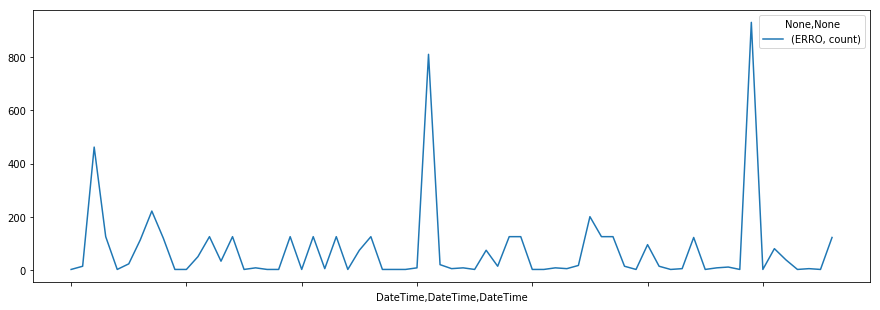

In [55]:
dataframeErroGP = dataframeErro.groupby([dataframeErro.index.month, dataframeErro.index.day, 
                                          dataframeErro.index.hour]).agg({    
    'ERRO': ['count']
})
dataframeErroGP.plot(figsize=(15, 5))



### Relação de Erros

In [46]:
ddfpidGP = dataframeErro.groupby(['ERRO']).agg({    
    'ERRO': ['count']
})
ddfpidGP = ddfpidGP.sort_values(by=[('ERRO', 'count')],ascending=False)
ddfpidGP

,ERRO
,count
ERRO,
ERRO:************:Alteracao pra tratar qttentativa*****,1734
ERRO:************:Marco status com E sem tentativa*****,1718
ERRO:************: [2] Entidade 00008: Registro nao considerado na carga.,750
ERRO:************: [1] Entidade 00012: Parametros inválidos.,588
ERRO:************: [1] Entidade 00008: Parametros invalidos.,370
ERRO:************:Marco status com A para tentativa*****,16
ERRO:ORA-01012: not logged on,15
ERRO:************: [4] Entidade 00001: N?o existe tipo de documento: VI_TPDOCUMENTO.,10


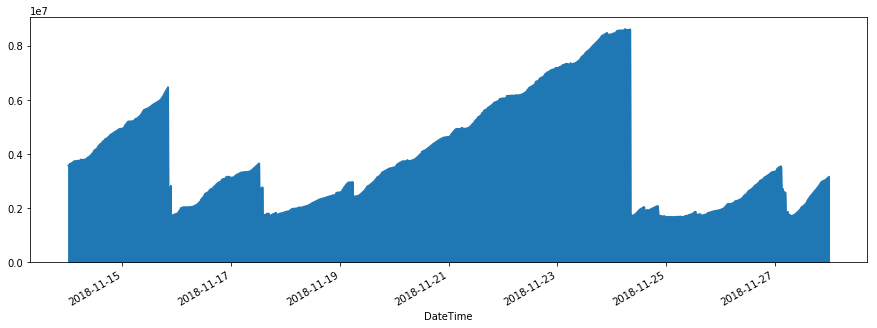

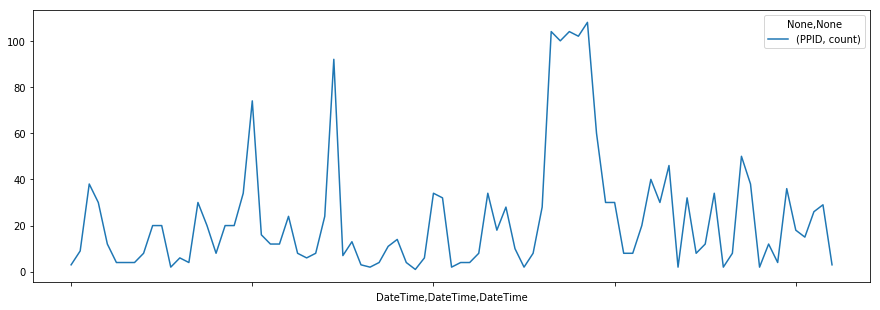

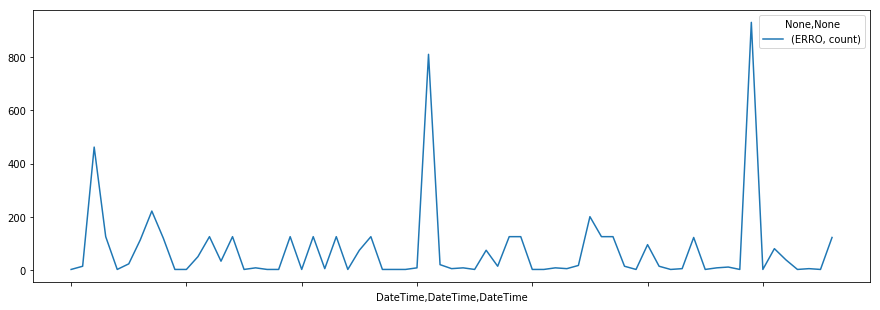

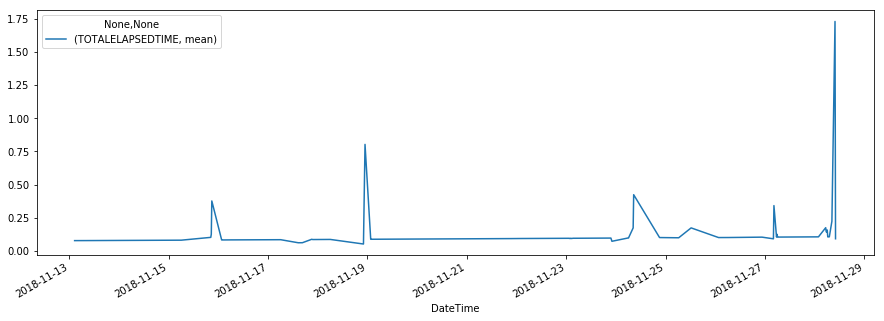

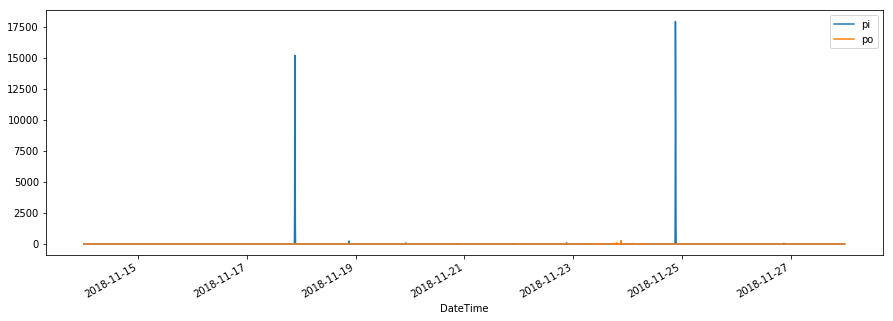

In [40]:
dataframevmstat['avm'].plot.area(figsize=(15, 5))
gp_totalppid1.plot(figsize=(15, 5))
dataframeErroGP.plot(figsize=(15, 5))
gp_teste.plot(figsize=(15, 5))
dfSW.plot(figsize=(15, 5))



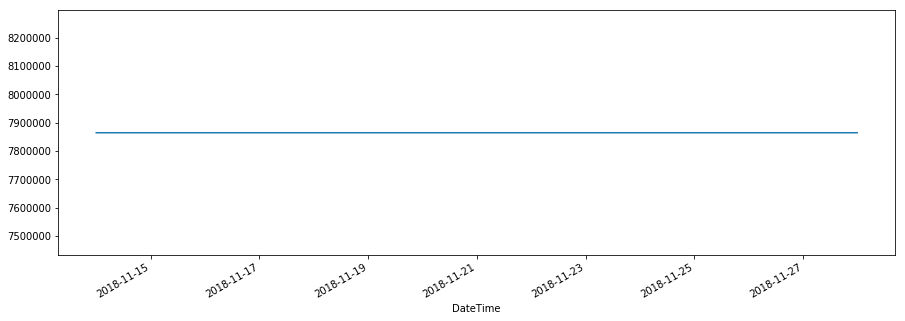

In [57]:
dataframevmstat['instmem'].plot(figsize=(15, 5))

In [61]:
dataframevmstat.head()

,date,time,r,b,avm,free,re,pi,po,fr,...,iodones,lock_misses,pct_swap_used,total_swap,numperm,instmem,numproc,entitled_capacity,online_lcpus,oneline_vcpus
DateTime,,,,,,,,,,,,,,,,,,,,,
2018-11-14 00:00:00,2018-11-14,00:00:56,1.0,0.0,3564236,3553470,0,0,0,0,...,0,0,4.86,4325376.0,10.19,7864320.0,4,4.0,8,4
2018-11-14 00:05:00,2018-11-14,00:05:56,1.0,0.0,3566593,3551603,0,0,0,0,...,0,0,4.86,4325376.0,10.18,7864320.0,4,4.0,8,4
2018-11-14 00:10:00,2018-11-14,00:10:56,1.0,0.0,3571755,3546437,0,0,0,0,...,0,0,4.86,4325376.0,10.18,7864320.0,4,4.0,8,4
2018-11-14 00:15:00,2018-11-14,00:15:56,1.0,0.0,3577686,3540500,0,0,0,0,...,0,0,4.86,4325376.0,10.18,7864320.0,4,4.0,8,4
2018-11-14 00:20:00,2018-11-14,00:20:56,1.0,0.0,3585313,3532866,0,0,0,0,...,0,0,4.86,4325376.0,10.18,7864320.0,4,4.0,8,4


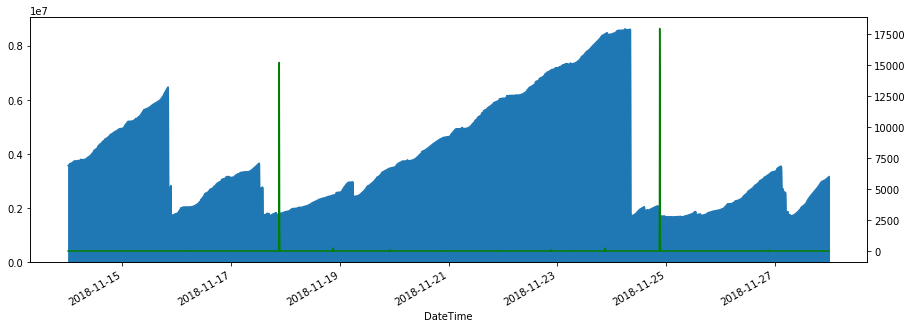

In [66]:
dataframevmstat['avm'].plot.area(figsize=(15, 5))
dataframevmstat['pi'].plot(figsize=(15, 5),secondary_y=True,style='g')



In [56]:
# IPython 
import IPython
from IPython.core.display import HTML
from IPython.display import Image



#                 Run (once) to allow nice html output as report (optional) 


"""
Hide code cells in an IPython notebook or exported HTML using javascript. 
Taken from Max Masnick's answer in 
http://stackoverflow.com/questions/27934885/how-to-hide-code-from-cells-in-ipython-notebook-visualized-with-nbviewer.
"""

# Example: di.display_html('<h3>%s:</h3>' % str, raw=True)
import IPython.core.display as di

# This line will hide code by default when the notebook is exported as HTML
di.display_html(
    '<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area, .output_stderr").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

CSS = """.input_area .output_stderr {height: 2.0em; overflow: hidden}"""  # changes input_subarea width to 1 visible line
HTML('<style>{}</style>'.format(CSS))

# This line will add a button to toggle visibility of code blocks, for use with the HTML export version
di.display_html('''<button onclick="jQuery('.input_area').toggle(); jQuery('.prompt').toggle();">Click in rendered .html output only, toggles the code</button>''', raw=True)

Click in rendered .html output only, toggles the code